### Ответы на вопросы

Данных очень мало, поэтому сложные модели хорошо не обучить. Поэтому в качестве классификаторов будем пробовать различные модели классификации, которые могут быть эффективными на небольшом объеме обучающих данных: logreg, svm, k-neighb clf. Как будем препроцессить данные? Есть два подхода, чистить наши данные и нормализовать их, а потом пропускать через трансформер, например bow или tf-idf. Или же можно пропустить их через модели которые на выходе выдают векторные представления слов (word2vec, fasttext, glove) и потом нехитрыми операциями свести эти эмбеддинги к эмбеддингу предложения. Есть и другой подход, брать сырые данные и пропускать через предобученный трансформер и тоже получать эмбеддинги предложений.

Я провел эксперименты с моделями обучающимися на TF-IDF и FastText эмбеддингах предложений.

Очистка данных (все то что неинформативно в контексте сентимента текста):
1.   удаление ссылок
2.   удаление тегов @name
3.   удаление метки ретвитов: "RT"
4.   удаление пунктуации
5.   удаление цифр
6.   удаление символов

Нормализация данных (опциональная):
1.   Лемматизация/Стемминг
2.   Удаление стоп слов

Сразу отмечу, что в чистке данных мы и удаляли текстовые смайлы (^_^, :( , =) и тд), которые закладывают в себе позитивную или негативную окраску текста. Это было сделано потому, что основываясь только на смайлах (грустные или веселые) можно сделать почти идеальный классификатор! Это может негативно повлиять на обучение и дать сильное смещение на них. То есть мы можем получить хорошее качество на этих данных, но когда придут новые, наша модель возможно не покажет такие успешные результаты (например на входе будет просто текст, без смайликов, либо негативный текст с кучей ироничных позитивных смайликов). Мы хотим получить модель с хорошей обобщающей способностью, поэтому нам необходим такой препроцессинг.

Далее я написал пайплайн, обучения моделей на кроссвалидации (изначально стратифицировано делим трейн-тест 80 на 20) и выбираем лучшую модель. В качестве метрики берем accuracy (данные сбалансированы по классам), у итоговой модели еще смотрим на roc-auc (для оценки семейства алгоритмов по порогам. данные балансные поэтому можно использовать roc-auc).

В контексте данной задачи классификации основная проблема в данных. Они не очень качественные, и малый размер выборки. Рассмотрим ситуацию, когда у нас есть хорошо размеченный большой датасет. Теперь мы можем пообучать на них более сложные модели. Я бы попробовал Biderectional-LSTM/GRU/BERT. С упором на последний. У таких моделей будет существенно более глубокое понимание семантического контекста предложения. Плюс можно попробовать различные техники аугментации, чтобы получить еще более разношерстный датасет: перестановка слов в предложении, синонимизация (замена слов на синонимы), добавление шума (случайная замена символов в небольшом количестве, добавление/удаление текстовых эмоджи, добавление/удаление пунктуации, замена регистра слов или первых букв и тд).

### Анализ данных и моделирование

In [ ]:
%pip install pymorphy2
%pip install fasttext

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pymorphy2
import fasttext
from huggingface_hub import hf_hub_download

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

nltk.download('stopwords')
nltk.download('punkt')

FASTTEXT_MODEL = fasttext.load_model(hf_hub_download('facebook/fasttext-ru-vectors', 'model.bin'))
MORPH_ANALYZER = pymorphy2.MorphAnalyzer()
RU_STOP_WORDS = set(stopwords.words('russian'))

sns.set_theme()
%matplotlib inline

In [67]:
df = pd.read_csv('tweets.csv')

In [68]:
print(f'Number of tweets: {len(df)}')

Number of tweets: 1000


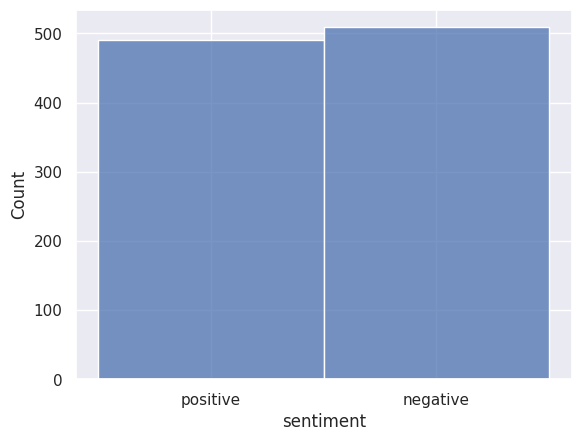

In [69]:
sns.histplot(data=df, x="sentiment")
plt.show()

In [70]:
def show_random_items(df: pd.DataFrame, k: int = 1) -> None:
    item = df.sample(k)

    for i in range(k):
        print(item.iloc[i]['sentiment'])
        print(item.iloc[i]['text'])
        print()

show_random_items(df, 10)

positive
@Mary__Zzz дерьмо случается, видимо не судьба тебе на тгп попасть)

positive
В общем, надеюсь,котейка будет жить и расти и через месяц,если все будет хорошо, я еще раз спрошу желающих)

positive
RT @YanaMandrakova: Час прогулки с моей Ол, красные носы, морозные щечки и хорошее настроение!) все в лучших традициях зимушки зимы!))) htt…

positive
Или как у крайон поп
Гееет, сееееет, редииии, ГОУ :D

negative
Как же хочу научиться играть на синтезаторе :(

negative
@_momsen_ как мне все это знакомо! тупо кроме учебы перестало все волновать! почему так?(

negative
Праздник не задается;( Сначала упал потолок, теперь стекло разбили;(

negative
@Photo_Nikita @sd0107 @pastya_nastya жестокий мир (

positive
Сегодня и вчера самые лучшие дни! Но не только из-за др...кто знает тот поймёт))))))

negative
Учишься ли ты на своих ошибках? — К сожалению не всегда( http://t.co/leVlpGjzs2



In [71]:
df['target'] = (df.sentiment == 'positive').astype(int)

### Почти идеальный классификатор

In [73]:
def dummy_classifier(s: str) -> int:
    if (':D' in s) or ('^_^' in s) or (':*' in s) or (':-D' in s) or (')' in s):
        return 1
    else:
        return 0

In [79]:
dummy_pred = df.text.apply(dummy_classifier)
wrong_pred_texts = df[dummy_pred != df.target]
print(f'Неправильно предсказано: {len(wrong_pred_texts)} текст')

show_random_items(wrong_pred_texts, len(wrong_pred_texts))

Неправильно предсказано: 1 текст
negative
@H1mkinet а у кого-то завтра работа :-D :-( поверь,я лучше бы поиграл бы :-D



Тут accuracy = 0.999, хотя классификатор вообще не смотрим на текст, это как раз то о чем я писал выше.

In [ ]:
class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator=None):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

class TransformerSwitcher(TransformerMixin, BaseEstimator):
    def __init__(self, transformer=None):
        self.transformer = transformer

    def fit(self, X, y=None):
        return self.transformer.fit(X)

    def transform(self, X):
        return self.transformer.transform(X)

In [57]:
class TextPreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, remove_stop_words: bool = False, lemmatize: bool = False):
        self.lemmatize = lemmatize
        self.remove_stop_words = remove_stop_words

    def __clean_text(self, s: str) -> str:
        s = re.sub(r"http\S+", "", s)
        s = re.sub(r'[\S]+\.(net|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil|me|ua|io|kz|by)[\S]*\s?','', s) # remove links
        s = re.sub(r"RT @\S+", "", s) # remove construnction "RT @name:"
        s = re.sub(r"@\S+", "", s) # remove construction "@name"
        s = s.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
        s = re.sub("\d", ' ', s) # remove digits
        s = re.sub(r'[a-zA-Z]', ' ', s) # remove all english symbols
        s = ' '.join(s.split())
        s = s.lower()
        return s

    def __prepare_text(self, s: str) -> str:
        s = self.__clean_text(s)
        tokens = word_tokenize(s)
        if self.remove_stop_words:
            tokens = [word for word in tokens if word not in RU_STOP_WORDS] # remove stop words

        if self.lemmatize:
            tokens = [MORPH_ANALYZER.parse(word)[0].normal_form for word in tokens] # lemmatize text

        s = ' '.join(s.split())
        return s

    def fit(self, X: List[str], y: List[int] = None):
        return self

    def transform(self, X: List[str]) -> List[str]:
        return [self.__prepare_text(text) for text in X]

class FastTextTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X: List[str], y: List[int] = None):
        return self

    def transform(self, X: List[str]) -> List[str]:
        return [FASTTEXT_MODEL.get_sentence_vector(text) for text in X] # get sentence embeddings

In [58]:
# разбивание выборку на тест и трейн (800-200) примеров,
X_train, X_test, y_train, y_test = train_test_split(df.text,
                                                    df.target,
                                                    stratify=df.target,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
# Подбираем лучшую модель и метод получения эмбеддингов текста различными способами
# Используем кросс-валидацию, на 4 бинах

pipeline = Pipeline([
    ('text_prep', TextPreprocessingTransformer()),
    ('text_vect', TransformerSwitcher()),
    ('clf', ClfSwitcher())
])

parameters = [
    {
        'clf__estimator': [LogisticRegression(random_state=42)],
        'clf__estimator__penalty': ['l2', 'l1'],
        'clf__estimator__solver': ['liblinear'],
        'clf__estimator__C': np.logspace(-3, 3, num = 6),
        'text_vect__transformer': [TfidfVectorizer(ngram_range=(1,1)), TfidfVectorizer(ngram_range=(1,2)), FastTextTransformer()],
        'text_prep__remove_stop_words': [False, True],
        'text_prep__lemmatize': [False, True]

    },
    {
        'clf__estimator': [SVC(random_state=42)],
        'clf__estimator__C': np.logspace(-3, 3, num = 6),
        'clf__estimator__kernel': ['linear', 'poly', 'rbf'],
        'clf__estimator__degree': [3, 5, 7],
        'text_vect__transformer': [TfidfVectorizer(ngram_range=(1,1)), TfidfVectorizer(ngram_range=(1,2)), FastTextTransformer()],
        'text_prep__remove_stop_words': [False, True],
        'text_prep__lemmatize': [False, True]
    },
    {
        'clf__estimator': [KNeighborsClassifier()],
        'clf__estimator__n_neighbors': [1, 3, 5, 7],
        'text_vect__transformer': [TfidfVectorizer(ngram_range=(1,1)), TfidfVectorizer(ngram_range=(1,2)), FastTextTransformer()],
        'text_prep__remove_stop_words': [False, True],
        'text_prep__lemmatize': [False, True]
    }
]

cv_grid = GridSearchCV(pipeline, param_grid=parameters, cv=4, verbose=10, scoring='accuracy', refit=True, error_score="raise")
cv_grid.fit(X_train, y_train)

In [86]:
best_estimator = cv_grid.best_estimator_
best_estimator

Pipeline(steps=[('text_prep',
                 TextPreprocessingTransformer(lemmatize=False,
                                              remove_stop_words=False)),
                ('text_vect',
                 TransformerSwitcher(transformer=FastTextTransformer())),
                ('clf',
                 ClfSwitcher(estimator=LogisticRegression(C=3.981071705534969,
                                                          penalty='l1',
                                                          random_state=42,
                                                          solver='liblinear')))])

In [84]:
print(f'Best parametres: {cv_grid.best_params_}')

Best parametres: {'clf__estimator': LogisticRegression(random_state=42), 'clf__estimator__C': 3.981071705534969, 'clf__estimator__penalty': 'l1', 'clf__estimator__solver': 'liblinear', 'text_prep__lemmatize': False, 'text_prep__remove_stop_words': False, 'text_vect__transformer': FastTextTransformer()}


In [88]:
print(f'Mean cross-validated accuracy score of the best_estimator: {cv_grid.best_score_:.3f}')

Mean cross-validated accuracy score of the best_estimator: 0.641


Как можно видеть, лучшая модель **на этих данных** - это Логистическая регрессия с L1 регуляризацией, обученная на текстах (без лематизации и удаления стоп слов) пропущенных через fasttext.


In [90]:
pred_test = best_estimator.predict(X_test)
pred_prob_test = best_estimator.predict_proba(X_test)

In [96]:
acc = accuracy_score(y_test, pred_test)
print(f'Best estimator test accuracy: {acc:.3f}')

Best estimator test accuracy: 0.610


In [97]:
def plot_roc_curve(probs: List[float], targets: List[int]) -> None:
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

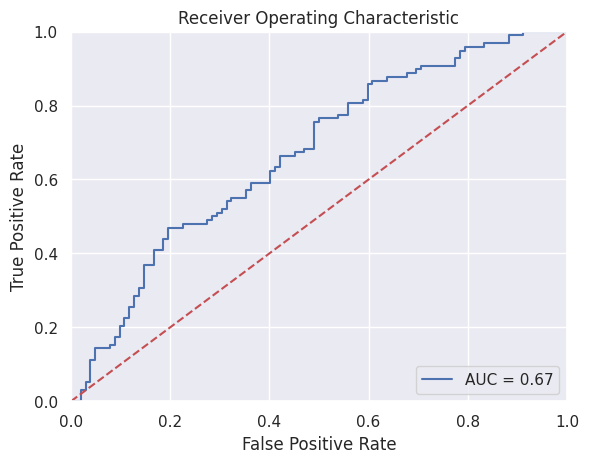

In [98]:
plot_roc_curve(pred_prob_test, y_test)

Мы получили ROC-AUC на тесте 0.67.  

Метрики небольшие из-за проблем с данными, но для сравнения можем показать что случайный классификатор будет давать 50% accuracy:

In [95]:
n_exp = 100
rand_acc = 0
for i in range(n_exp):
    random_pred = np.random.randint(2, size=len(y_test))
    rand_acc += (random_pred == y_test).mean()
rand_acc /= n_exp
print(f'Random classifier test accuracy:  {rand_acc:.3f}')

Random classifier test accuracy:  0.501
